##This notebook deals with answering the following questions: 
1) Identifying and categorizing host genes in viral genomes, and <br>
2) quantifying the sequence similarity between viral structural elements across and within different host groups. 

In [4]:
#This is a block of code that is required for answering both questions. By now, it should look familiar as a staple of 
#every notebook. The output of it is lengthData, which contains various types of information (e.g. number of proteins
#genome length, host lineage, viral lineage, etc) for each virus. 

import numpy as np
import matplotlib.pyplot as plt
import ete3 as ete
import os
import io
import Bio
import random
import scipy 
import scipy.stats as stats
from functools import *
from Bio import Entrez
from Bio import SeqIO
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import re
%matplotlib inline
sns.set_context("paper")

#as part of quality control the following viruses had to be omitted from our analysis
#they contain misannotations or mislabeled hosts, etc. 
badFolders = ['Acyrthosiphon_pisum_secondary_endosymbiont_phage_1_uid14047', 'Aureococcus_anophagefferens_virus_MM_2014_uid258005', 'Dragonfly_associated_microphage_1_uid177547', 'Enterobacter_phage_PG7_uid240014', 'Escherichia_phage_vB_EcoM_JS09_uid248321', 'Lactobacillus_phage_LL_H_uid19803', 'Providencia_phage_Redjac_uid177540', 'Pseudoalteromonas_phage_RIO_1_uid206039', 'Sputnik_virophage_2_uid243067', 'Sputnik_virophage_3_uid243065', 'Staphylococcus_phage_6ec_uid253318', 'Streptococcus_phage_DCC1738_uid253219', 'Streptococcus_phage_IC1_uid253220', 'Streptococcus_phage_K13_uid253223', 'Streptococcus_phage_SMP_uid18529', 'Vibrio_phage_CP_T1_uid181062', 'Vibrio_phage_vpms1_uid212709', 'Vibrio_phage_VPUSM_8_uid227006',  'Abaca_bunchy_top_virus_uid28697','Shallot_yellow_stripe_virus_uid15745','Equine_rhinitis_A_virus_uid15205','African_pouched_rat_arterivirus_uid274797','Spilanthes_yellow_vein_virus_uid19779', 'Velvet_bean_severe_mosaic_virus_uid41175','Paramecium_bursaria_Chlorella_virus_FR483_uid18305','Human_endogenous_retrovirus_K113_uid222261','Acholeplasma_phage_MV_L1_uid14573']
#viruses whose lineage is improperly annotated (they don't belong to any Baltimore group)
unknowns= ['Bacillus_phage_phBC6A51_uid15021', 'Bacillus_phage_phBC6A52_uid15022', 'Badger_feces_associated_gemycircularvirus_uid281125', 'Chaetoceros_DNA_virus_7_uid237558', 'Chaetoceros_lorenzianus_DNA_Virus_uid63565', 'Chaetoceros_tenuissimus_DNA_virus_uid60753', 'Cladosporium_cladosporioides_virus_1_uid258308', 'Enterobacteria_phage_YYZ_2008_uid32231', 'European_mountain_ash_ringspot_associated_virus_uid39973', 'Faecal_associated_gemycircularvirus_3_uid268557', 'Faecal_associated_gemycircularvirus_4_uid268556', 'Faecal_associated_gemycircularvirus_5_uid268555', 'Faecal_associated_gemycircularvirus_6_uid268554', 'Faecal_associated_gemycircularvirus_7_uid268553', 'Gentian_ovary_ring_spot_virus_uid256090', 'Geobacillus_virus_E2_uid19797', 'Glossina_pallidipes_salivary_gland_hypertrophy_virus_uid28839', 'Haloarcula_hispanica_icosahedral_virus_2_uid109269', 'Haloarcula_phage_SH1_uid15535', 'Halovirus_PH1_uid196975', 'Halovirus_VNH_1_uid262927', 'Human_genital_associated_circular_DNA_virus_1_uid281399', 'Lactobacillus_johnsonii_prophage_Lj771_uid28145', 'Magnaporthe_oryzae_RNA_virus_uid272442', 'Mongoose_feces_associated_gemycircularvirus_a_uid281407', 'Mongoose_feces_associated_gemycircularvirus_b_uid281406', 'Mongoose_feces_associated_gemycircularvirus_c_uid281404', 'Mongoose_feces_associated_gemycircularvirus_d_uid281405', 'Mycoplasma_phage_phiMFV1_uid14387', 'Penicillium_roqueforti_dsRNA_mycovirus_1_uid258162', 'Phage_Gifsy_1_uid32269', 'Phage_Gifsy_2_uid32271', 'Pigeonpea_cryptic_virus_uid244664', 'Planaria_asexual_strain_specific_virus_like_element_type_1_uid14140', 'Pseudomonas_phage_phi_Pto_bp6g_uid240724', 'Rhizoctonia_fumigata_mycovirus_uid283068', 'Rhodococcus_phage_REQ2_uid81171', 'Rhodococcus_phage_REQ3_uid81175', 'Rose_rosette_virus_uid64937', 'Rosellinia_necatrix_fusarivirus_1_uid255787', 'Rosellinia_necatrix_megabirnavirus_1_W779_uid41609', 'Salisaeta_icosahedral_phage_1_uid167575', 'Salmonella_phage_Fels_1_uid29267', 'Sodalis_phage_phiSG1_uid16583', 'Staphylococcus_phage_phi2958PVL_uid32173', 'Staphylococcus_phage_tp310_1_uid20659', 'Staphylococcus_phage_tp310_3_uid20663', 'Stenotrophomonas_phage_phiSMA9_uid15493', 'Streptococcus_phage_20617_uid239271', 'Streptococcus_phage_phiBHN167_uid227353', 'Streptococcus_pyogenes_phage_315_1_uid14533', 'Streptococcus_pyogenes_phage_315_2_uid14528', 'Streptococcus_pyogenes_phage_315_3_uid14529', 'Streptococcus_pyogenes_phage_315_4_uid14530', 'Streptococcus_pyogenes_phage_315_5_uid14531', 'Streptococcus_pyogenes_phage_315_6_uid14532', 'Tanay_virus_uid246129', 'Thermococcus_prieurii_virus_1_uid84407', 'Thermus_phage_IN93_uid14235', 'Thermus_phage_P23_77_uid40235']
badFolders=badFolders+unknowns
#these are satellite viruses 
sats = ['Ageratum_conyzoides_associated_symptomless_alphasatellite_uid259293', 'Ageratum_enation_alphasatellite_uid181994', 'Ageratum_leaf_curl_betasatellite_uid195929', 'Ageratum_leaf_curl_Cameroon_betasatellite_uid36669', 'Ageratum_yellow_leaf_curl_betasatellite_uid14439', 'Ageratum_yellow_vein_China_alphasatellite_uid237561', 'Ageratum_yellow_vein_China_virus_associated_DNA_beta_uid15515', 'Ageratum_yellow_vein_Singapore_alphasatellite_uid14232', 'Ageratum_yellow_vein_virus_satellite_DNA_beta_uid14444', 'Alternanthera_yellow_vein_virus_satellite_DNA_beta_uid19833', 'Andrographis_yellow_vein_leaf_curl_betasatellite_uid243492', 'Bhendi_yellow_vein_India_betasatellite__India_Aurangabad_OY164_2006__uid61557', 'Bhendi_yellow_vein_mosaic_betasatellite__India_Coimbator_OYCO1_2005__uid61777', 'Bhendi_yellow_vein_mosaic_virus_associated_alphasatellite_uid174781', 'Bhendi_yellow_vein_mosaic_virus_satellite_DNA_beta_uid14445', 'Black_medic_leafroll_alphasatellite_1_uid243500', 'Cardamom_bushy_dwarf_virus_satellite_uid230064', 'Cassava_mosaic_Madagascar_alphasatellite_uid175666', 'Chili_leaf_curl_Bhatinda_betasatellite_uid206467', 'Chilli_leaf_curl_alphasatellite_uid253224', 'Chilli_leaf_curl_Multan_alphasatellite_uid39933', 'Chilli_leaf_curl_virus_satellite_DNA_beta_uid14441', 'Cleome_leaf_crumple_virus_associated_DNA_1_uid60045', 'Corchorus_yellow_vein_mosaic_betasatellite_uid192608', 'Cotton_leaf_curl_Burewala_alphasatellite_uid45935', 'Cotton_leaf_curl_Burewala_betasatellite_uid45933', 'Cotton_leaf_curl_Gezira_alphasatellite_uid42507', 'Cotton_leaf_curl_Gezira_virus_satellite_DNA_beta_uid15166', 'Cotton_leaf_curl_Multan_betasatellite_uid15780', 'Cotton_leaf_curl_virus_associated_DNA_1_isolate_Lucknow_uid65305', 'Cotton_leaf_curl_virus_associated_DNA_beta_uid14438', 'Cotton_leaf_curl_virus_betasatellite_uid162497', 'Cowpea_severe_leaf_curl_associated_DNA_beta_uid15157', 'Croton_yellow_vein_mosaic_alphasatellite_uid45931', 'Croton_yellow_vein_mosaic_betasatellite_uid18249', 'Cuban_alphasatellite_1_uid210798', 'Dragonfly_associated_alphasatellite_uid181244', 'Emilia_yellow_vein_virus_associated_DNA_beta_uid37893', 'Erectites_yellow_mosaic_virus_satellite_DNA_beta_uid19827', 'Eupatorium_yellow_vein_virus_satellite_DNA_beta_uid14447', 'Faba_bean_necrotic_stunt_alphasatellite_1_uid243499', 'Faba_bean_necrotic_stunt_alphasatellite_2_uid243498', 'French_bean_leaf_curl_betasatellite_Kanpur_uid169556', 'Gossypium_darwinii_symptomless_alphasatellite_uid39593', 'Gossypium_davidsonii_symptomless_alphasatellite_uid39589', 'Gossypium_mustilinum_symptomless_alphasatellite_uid39591', 'Grapevine_satellite_virus_uid208539', 'Guar_leaf_curl_alphasatellite_uid193981', 'Hedyotis_uncinella_yellow_mosaic_betasatellite_uid230991', 'Honeysuckle_yellow_vein_mosaic_disease_associated_satellite_DNA_beta_uid19863', 'Honeysuckle_yellow_vein_mosaic_virus_satellite_DNA_beta_uid14620', 'Leucas_zeylanica_yellow_vein_virus_satellite_DNA_beta_uid41305', 'Ludwigia_leaf_distortion_betasatellite__India_Amadalavalasa_Hibiscus_2007__uid29233', 'Ludwigia_yellow_vein_virus_associated_DNA_beta_uid15561', 'Luffa_puckering_and_leaf_distortion_associated_betasatellite__India_Gurdaspur_Okra_2013__uid253218', 'Luffa_puckering_and_leaf_distortion_associated_DNA_beta_uid15779', 'Malachra_yellow_vein_mosaic_virus_associated_satellite_DNA_beta_uid28727', 'Malvastrum_leaf_curl_betasatellite_uid16301', 'Malvastrum_leaf_curl_Guangdong_betasatellite_uid243827', 'Malvastrum_yellow_vein_Yunnan_virus_satellite_DNA_beta_uid14567', 'Melon_chlorotic_mosaic_virus_associated_alphasatellite_uid51413', 'Mesta_yellow_vein_mosaic_virus_alphasatellite__India_Hoshiarpur_Okra_2013__uid253217', 'Mesta_yellow_vein_mosaic_virus_associated_alphasatellite_uid174780', 'Mesta_yellow_vein_mosaic_virus_associated_DNA_beta_uid21015', 'Milk_vetch_dwarf_C10_alphasatellite_uid240682', 'Mirabilis_leaf_curl_India_virus_associated_betasatellite_uid255800', 'Mungbean_yellow_mosaic_India_virus_associated_betasatellite__India__Faizabad__Cow_Pea_2012__uid177773', 'Nanovirus_like_particle_uid14386', 'Okra_enation_leaf_curl_betasatellite__India_Sonipat_EL10_2006__uid61781', 'Okra_leaf_curl_Mali_virus_satellite_DNA_beta_uid20323', 'Okra_yellow_vein_disease_associated_sequence_uid14443', 'Olive_viral_satellite_RNA_uid230268', 'Papaya_leaf_curl_alphasatellite_uid233414', 'Papaya_leaf_curl_China_virus_satellite_DNA_beta_uid19819', 'Pepper_leaf_curl_virus_satellite_DNA_beta_uid28283', 'Pepper_leaf_curl_Yunnan_virus_satellite_DNA_beta_uid29415', 'Potato_apical_leaf_curl_disease_associated_satellite_DNA_beta_uid18323', 'Radish_leaf_curl_virus_betasatellite_uid28281', 'Sida_leaf_curl_virus_satellite_DNA_beta_uid19823', 'Sida_yellow_mosaic_virus_China_associated_DNA_beta_uid15514', 'Sida_yellow_vein_China_alphasatellite_uid238950', 'Siegesbeckia_yellow_vein_virus_associated_DNA_beta_uid17269', 'Subterranean_clover_stunt_C6_alphasatellite_uid14180', 'Synedrella_leaf_curl_alphasatellite_uid263034', 'Tobacco_leaf_chlorosis_betasatellite_uid178075', 'Tobacco_leaf_curl_disease_associated_sequence_uid14442', 'Tobacco_leaf_curl_PUSA_alphasatellite_uid56023', 'Tobacco_leaf_curl_virus_associated_DNA_beta_uid45925', 'Tomato_leaf_curl_Bangladesh_betasatellite_uid56017', 'Tomato_leaf_curl_Gandhinagar_betasatellite_uid231683', 'Tomato_leaf_curl_Hajipur_betasatellite_uid175587', 'Tomato_leaf_curl_Joydebpur_virus_satellite_DNA_beta_uid28273', 'Tomato_leaf_curl_Karnataka_alphasatellite_uid181995', 'Tomato_leaf_curl_Pakistan_virus_associated_DNA_1_uid38463', 'Tomato_leaf_curl_Patna_betasatellite_uid36541', 'Tomato_leaf_curl_Togo_betasatellite_Togo_2006__uid60629', 'Tomato_leaf_curl_Yemen_betasatellite_uid177643', 'Tomato_yellow_leaf_curl_China_betasatellite_uid181248', 'Tomato_yellow_leaf_curl_Vietnam_virus_satellite_DNA_beta_uid19829', 'TYLCCNV_Y322__satellite_DNA_beta_uid16338', 'Vernonia_yellow_vein_betasatellite_uid41303', 'Vernonia_yellow_vein_Fujian_virus_alphasatellite_uid72145', 'Vernonia_yellow_vein_Fujian_virus_betasatellite_uid72143', 'Zinnia_leaf_curl_disease_associated_sequence_uid14440', 'Zinnia_leaf_curl_virus_associated_DNA_beta_uid14538']


def getTaxidFromGenomeFolder(genome_folder):
    '''
    Takes an rpt file for a genome and returns the taxid in it.
    '''   
    if folder not in badFolders and folder not in sats:
        with open(os.path.join('all_rpt', folder, os.listdir(os.path.join('all_rpt', folder))[0])) as rpt_file:
            for line in rpt_file:
                if line.startswith('Taxid: '):
                    return int(line[7:-1])
                

def getHostTaxidFromGenomeFolder(genome_folder):
    '''
    Takes a folder containing an asn file and returns the taxid of the host of
    the virus described by that asn file.
    '''
    if folder not in badFolders and folder not in sats :
        with open('folderToHostTaxid.txt', 'r') as taxid2host:
            for line in taxid2host:
                if genome_folder in line:
                    return int(line.split('\t')[1][:-1])
        return 0
    

def getGenomeLengthFromGenomeFolder(genome_folder):
    total = 0
    if folder not in badFolders and folder not in sats :
        for file in os.listdir(os.path.join('all_ptt', folder)):
            with open(os.path.join('all_ptt', folder, file)) as ptt_file:
                line = ptt_file.readline()
                index = line.find('- 1..')
                if index == -1:
                    return -1
                num = line[index + 5 : -1]
                total += int(num)
        return total

    
# def getProteinSeqsForEachVirus(folder):    
#     for file in os.listdir(os.path.join('all_faa', folder)):  
#         #these folders contain genomes with misannotation of gene overlap,non-coding DNA, or host information from NCBI. 
#         if folder not in badFolders and folder not in sats :
#             #opening a file to hold the protein sequences for each virus so I can BLASTX them later. 
#             filename = folder + '_phageProteins'
#             inputFileNameTXT = filename + '.txt'
#             fo = open(inputFileNameTXT, 'w')
#             with open(os.path.join('all_faa', folder, file)) as faa_file:
#                 for line in faa_file:
#                     fo.write(line +'\n')
#                 fo.close()
#     return 0
 

def getProtienNamesFromGenomeFolder(folder):
    protVec=[]
    for file in os.listdir(os.path.join('all_ptt', folder)):
        #these folders contain genomes with misannotation of gene overlap, non-coding DNA, or host information from NCBI. 
        if folder not in badFolders and folder not in sats:
            with open(os.path.join('all_ptt', folder, file)) as ptt_file:
                line = ptt_file.readline()
                line = ptt_file.readline()
                line = ptt_file.readline()               
                for line in ptt_file:                    
                    #this is to collect the name of proteins from ptt files                   
                    protVec.append(line.split('\t')[-1].rstrip())                                    
    return (protVec)
            
genomeLengths = []
lengthData = []
counter = 0
length_lists = []
hostTaxidList = []
taxidList = []
folders = []
proteinNames=[]
proteinSeqs=[]
dbObject = ete.NCBITaxa()

for folder in os.listdir('all_faa'):
    #these entries had problems with their gene overlap, protein, and noncoding annotation, need to be excluded    
    if folder not in badFolders and folder not in sats :   
        length_lists.append([])
        for fileName in os.listdir(os.path.join('all_faa', folder)):
            with open(os.path.join('all_faa', folder, fileName), 'r') as faa_file:
                proteins = SeqIO.parse(faa_file, 'fasta')
                for protein in proteins:
                    length_lists[counter].append(float(len(protein.seq)))

        hostTaxid = getHostTaxidFromGenomeFolder(folder)

        # viruses with unidentified hosts. Now they are out. 
        if hostTaxid and hostTaxid != 11086 and hostTaxid != 10036 and hostTaxid != 37965 and hostTaxid != 10640  and hostTaxid != 32644 and hostTaxid != 1 and hostTaxid != 212035 and hostTaxid != 1051671:
            taxidList.append(getTaxidFromGenomeFolder(folder))
            hostTaxidList.append(hostTaxid)
            genomeLengths.append(getGenomeLengthFromGenomeFolder(folder))
            folders.append(folder)
            proteinNames.append(getProtienNamesFromGenomeFolder(folder))
            #proteinSeqs.append(getProteinSeqsForEachVirus(folder))
            counter += 1
        else:
            length_lists = length_lists[:-1]

        #Uncomment the following lines to see the code's progress while its running        
        """
        if counter % 100 == 0:
            print(str(int(np.round(float(counter) * 100.0 / 2701.0))) + '% done.')
        """

taxidLineages = [dbObject.get_lineage(t) for t in taxidList]
englishLineages = [[str(rank) for rank in dbObject.translate_to_names(lin)]
                   for lin in taxidLineages]
hostTaxidLineages = [dbObject.get_lineage(t) for t in hostTaxidList]
hostEnglishLineages = [[str(rank) for rank in dbObject.translate_to_names(lin)] 
                       for lin in hostTaxidLineages]

for i in range(len(length_lists)):
    lengthData.append({'length_list' : length_lists[i],
                       'taxid' : taxidList[i],
                       'hostTaxid' : hostTaxidList[i],
                       'englishLineage' : englishLineages[i],
                       'taxidLineage' : taxidLineages[i],
                       'hostEnglishLineage' : hostEnglishLineages[i],
                       'hostTaxidLineage' : hostTaxidLineages[i],
                       'mean' : np.mean(length_lists[i]),
                       'std' : np.std(length_lists[i]),
                       'median' : np.median(length_lists[i]),
                       'numProteins' : len(length_lists[i]),
                       'proteinNames': proteinNames[i],
                       #'proteinSeqs': proteinSeqs[i],
                       'genomeLength' : genomeLengths[i],
                       'folder' : folders[i]})
                       
lengthData = [virus for virus in lengthData if virus['genomeLength'] != -1]



/Users/Gita/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


###Going through every blast output file to create a dataframe containing the top BLASTP hits for each dsDNA bacteriophage protein
Because we have already provided the output, you can skip this section and read in the output csv file instead (see next block of code). 
Note that this entire notebook deals with dsDNA bacterial viruses only. Other types of viruses are not included in this analysis. 

In [3]:
#app will be a massive dataframe containing all BLASTP hits for each dsDNA bacteriophage protein against the refseq
#bacterial proteins
app=[]
#this following dataframe is going to be similar to app, but more condensed (only containing the top 
#blast hit for each viral protein)
topH=[]
#this is a list containing the number of proteins with bacterial homologs (per virus)
homProtL=[]
#this is a list that reports the fraction of proteins (per virus) that is homologous 
#to bacterial proteins
homFracL=[]
#openining blastp output files (format 6)
filepath='blastBacterialFinalv2/'

for filename in os.listdir(filepath): 
    with io.open(os.path.join(filepath, filename), 'r',  encoding='windows-1252') as file:
        #creating a dataframe from each text file
        df=pd.read_table(file, sep='\t', names = ['nothing1', 'qgi', 'qlen'
                                                  ,'sgi', 'sacc', 'slen', 'pident', 'nident' 
                                                  ,'bitscore','evalue', 'staxids', 'stitle'
                                                  ,'superkingdom','phylum','class', 'order'
                                                  ,'family','genus','species'])
        #getting rid of the original heading
        df=df.drop(df.index[0])    
        #There are rows (blast results of a protein) without a description, 
        #so those rows are not going to be included
        df=df[df['stitle'].notnull()]
        #some additional data clean up, these two entries were never in the proper format
        df=df[df['stitle'].str.contains('soap lake', case=False)==False]
        df=df[df['stitle'].str.contains('Phage lysin, 1,4-beta-N-acetylmuramidase or lysozyme', 
                                        case=False)==False]
         
        #The stitle column contains information regarding both the protein, and the 
        #organism name, so I am simply going to capture
        #the organism description and the protein description from this column, 
        #seperate each into its own column, and get rid of stitle column later
        hitProtDesc = [re.search('(.+?) \[(.+?)\]', row).group(1) for row in df['stitle']] 
        hitOrgDesc = [re.search('(.+?) \[(.+)\]', row).group(2) for row in df['stitle']] 
        
        #For later steps, we need to get the list of GIs identifying select viral 
        #proteins that are homologous to bacterial proteins
        #going through each row in the dataframe and collecting only 
        #the gi number from the qgi column
        selProtGi=[row.split('|')[1] for row in df['qgi']]

        #I want to use the name of the output files to retrieve information about the 
        #virus that they contain protein information for
        #To do this though, I need to remove part of the filename        
        newFileName=filename.replace("_phageProteins_blastp_prot_bacteria_out_tax.txt","")
                
        #getting data (host and virus lineage information) about the
        #virus based on the previous step 
        hostData=[virus['hostEnglishLineage'] for virus in lengthData 
                  if virus['folder']==newFileName]
        virusData=[virus['englishLineage'][-1] for virus in lengthData 
                   if virus['folder']==newFileName]
        virusTaxid=[virus['taxid'] for virus in lengthData 
                    if virus['folder']==newFileName]
        hostTaxid=[virus['hostTaxid'] for virus in lengthData 
                   if virus['folder']==newFileName]
        
        #seeing how many proteins a given virus has...will add this info to the topHits later
        viralProts = [virus['numProteins'] for virus in lengthData 
                      if virus['folder']==newFileName]       
        
        #Getting some information about the proteins of a given virus
        #first I need to read files that are in phageProteins folder, because each file contains 
        #the phage's protein records. To step through those files, need to look for them with the 
        #right name, which does not contain _blastp_out so that part needs to be removed
        newFileName2=filename.replace("_blastp_prot_bacteria_out_tax","")       
        for fileName in os.listdir('phageProteins/'): 
            if fileName == newFileName2:
                with open(os.path.join('phageProteins/', fileName)) as file:
                    #will use list to store information about proteins' gi numbers and 
                    #descriptions for each virus
                    queryProtInfoL=[]
                    for line in file: 
                        #each protein record starts with >gi..., which is where the name and 
                        #gi information is held regarding each protein. 
                        if ">gi|" in line:
                            #using regular expressions to capture only the gi number and 
                            #the protein description. Here's an example:
                            # >gi|9626513|ref|NP_040810.1| protein L2_03 [Acholeplasma phage L2]
                            [gi, queryProtDesc] = re.search('>gi\|(.+?)\|.+?\|.+?\| (.+?) \['
                                                            , line).group(1,2)
                            #appending this info to lists
                            queryProtInfoL.append([gi, queryProtDesc])  
                            
                #now that we have information about all the proteins for each virus, 
                #we can add this information to the dataframe. However, in the case of 
                #blasting viral proteins against bacterial database, not all viral 
                #proteins will have a hit, so we want to collect information about the
                #select viral proteins that have homology to bacterial proteins, 
                #which we identified earlier
                queryDescL=[]
                for gi in selProtGi:
                    #selProtGi contains the GIs for viral proteins that have homology 
                    #to bacterial proteins for a given virus 
                    #queryProtInfoL contains the information regarding all 
                    #proteins for that virus
                    for vec in queryProtInfoL:
                        #format [gi, protein description]
                        if gi == vec[0]:
                            queryDescL.append(vec[1])
                                                                 
                #to save time, we want to quit this forloop if the file (the virus) we're 
                #looking for is already found
                break


        #changing the format of the hostData a little bit so I can add it to the dataframe  
        #short host data contains just the phylum and a couple of other higher up lineage information for the viral host
        hostData=hostData[0][:]
        shortHostData= hostData[3:6]
        hostSpecies=hostData[-1]
        shortHostData=' '.join(shortHostData)
        hostData=' '.join(hostData)
            
        #adding the host, virus, and protein information as columns to the exisiting dataframe
        df['queryDesc']=queryDescL
        df['hostTaxid']= hostTaxid[0]
        df['hostInfo']=hostData
        df['condensedHostInfo']=shortHostData
        df['hostSpecies']=hostSpecies
        df['virusTaxid']=virusTaxid[0]
        df['virusInfo']=virusData[0]   
        df['hitProtDesc']=hitProtDesc
        df['hitOrgDesc']=hitOrgDesc
        
        #This part is here to give a filtered version of the output ("topHits") as well as the full output 
        #("app" dataframe) the filter is working to take only the top blast hit for any protein (in addition to 
        #the 10^-10 evalue filter already in place)
        topHits=[]
        #this is the list of row indices in each blast report text file that contains the top hit
        #we want to take the very first hit (they are ordered based on e-value, so the first hit is the best
        #for a given protein)
        indexList=[0] 
        
        df = df.reset_index(drop=True)
        
        #the first gi number in the text file is the first element of giList
        giList=[df.iloc[0]['qgi'].split('|')[1]]
        #going through dataframe, row by row to get only rows that correspond to the the top blast hits to each protein
        for index, row in df.iterrows():
            #capturing the gi numbers from the 'qgi' column
            giNum=row['qgi'].split('|')[1]
            #we want to only add to giList another gi that is not already in the list, hence the counter "check"
            check=0
            for item in giList:
                if item == giNum:
                    #if there is another identical gi in the list, check>0, which will break the loop to save time
                    check=check+1
                    break
            #if the check however remains 0, it means we are dealing with a unique gi and we add it to our list
            if check==0:
                giList.append(giNum)
                indexList.append(index)
        
        
        #since we have a unique gi identified, we want to take that whole row from the df dataframe,
        #and create a new and more filtered dataframe called "topHits"                
        topHits=pd.DataFrame(df.iloc[indexList,:])
        
        #need this information for making a histogram of the number of viral proteins that have bacterial homologs
        numHomProts=len(indexList)
        homProtL.append(numHomProts)
        
        #seeing how many proteins a given virus has...will add this info to the topHits later
        viralProts = [virus['numProteins'] for virus in lengthData if virus['folder']==newFileName]        
        #this is to answer the question, "what fraction of proteins have bacterial homologs?"
        homFrac=numHomProts/viralProts[0]
        homFracL.append(homFrac)
               
        #adding some more information as columns of the exisiting dataframe (this is for the topHits)        
        topHits['numberOfProteins'] = viralProts[0]
        topHits['numberOfHomologousProteins'] = numHomProts
        topHits['fractionOfHomologousProteins']=homFrac
               
        
        #appending each dataframe to create one all-encompassing dataframe
        app.append(df)
        topH.append(topHits)
#concatenating the dataframes into one dataframe. This dataframe should contain information regarding all viral 
#proteins that had a hit to a bacterial protein
app = pd.concat(app, axis=0)
topH= pd.concat(topH, axis=0)
#dropping the columns that contain no useful information
app=app.drop(['nothing1', 'stitle'], 1)
topH=topH.drop(['nothing1', 'stitle'], 1)

#to save the dataframes to text files, uncomment the following lines
#app.to_csv('bactBlastOutputAnalyzed.txt', header=True, index=False, sep='\t')
topH.to_csv('bactBlastOutputAnalyzedTopHitsV2.txt', header=True, index=False, sep='\t')

                 
  

/Users/Gita/anaconda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (0,2,3,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


###Reading in the output from the previous block of code. 

In [5]:
filename = 'bactBlastOutputAnalyzedTopHitsV2.txt'
with io.open(filename, 'r',  encoding='windows-1252') as file:
    #creating a dataframe from the text file we created so the code above doesn't have to be rerun everytime
    #this is the same as the topH dataframe above, renaming it to keep a copy
    toph=pd.read_table(file, sep='\t')
      

###What fraction of viral proteins are homologous to bacterial proteins?


In [6]:
#total number of viral proteins homologous to bacterial proteins in our dataset. Note we're using the number of rows
#in the toph dataframe as proxy for the number of homologous proteins because each represents the top BLASTP hit, 
#and thus each viral protein is counted only once.  
homProtNum = toph.shape[0]
print('Total number of phage proteins with bacterial homologs: ', homProtNum)

#number of viruses that contain these homologous proteins
homVirusNum=len(toph['virusInfo'].unique())
print('Number of phages with at least one protein homologous to a bacterial protein: ', homVirusNum)

#what fraction of the phage proteome has homology to bacterial proteins?
#totProtNum is the total number of proteins that the viruses in our collection contain
totProtNum=toph.groupby(['virusInfo'])['numberOfProteins'].mean().sum()
print('Fraction of phage proteins homologous to bacterial proteins: ', np.round(homProtNum/totProtNum,2))



Total number of phage proteins with bacterial homologs:  50883
Number of phages with at least one protein homologous to a bacterial protein:  898
Fraction of phage proteins homologous to bacterial proteins:  0.58


###Identifying and filtering potential prophages 

In [7]:
#want to identify possible prophages by selecting viruses that have a high fraction of proteins that have 
#homologs in the same bacterial species as their host. I additionally impose that the homologs have a high percent 
#identity for the homologous relationship to be considered

#only selecting homologs with at least 50% sequence identity
b= toph[toph['pident']>=50]
#getting rid of entries that don't have any species assignment (the species refers to the bacterial species where
#the bacterial protein homolog was found)
b=b[b['species'].isnull()==False]
#only selecting those homologs that appear in the same bacterial species as the virus host
b = b[b.apply(lambda b: b['species'] in b['hostInfo'] , axis=1)]

#creating a dataframe containing viruses that pass through the previous filters 
a=pd.DataFrame(b.groupby('virusInfo')['qgi'].count() / b.groupby('virusInfo')['numberOfProteins'].mean(),
               columns = [ "fracHostProteins"]).reset_index()

#imposing yet another filter: this time, the fraction of homologous proteins should be at least 50% of the total 
#proteins in the virus genome have bacterial homologs. putPro represents the putative prophages based on these criteria
putPro=a[a>=0.5].dropna()
print('Number of putative prophages: ', putPro.shape[0])
putProL = putPro['virusInfo'].tolist()

#Here's a filtered toph dataframe, putative prophage proteins 
tophProFil=toph[toph['virusInfo'].isin(putProL)==False]
print('Number of putative prophage proteins: ', toph.shape[0]-tophProFil.shape[0])
putPro


Number of putative prophages:  173
Number of putative prophage proteins:  9959


,virusInfo,fracHostProteins
1,Acinetobacter phage Bphi-B1251,0.500000
9,Azospirillum phage Cd,0.968421
15,Bacillus phage BMBtp2,0.547170
23,Bacillus phage Cherry,0.607843
24,Bacillus phage Fah,0.600000
27,Bacillus phage IEBH,0.593023
39,Bacillus phage WBeta,0.641509
44,Bacillus phage phiCM3,0.642857
48,Bacteriophage APSE-2,0.975610
51,Bordetella phage BIP-1,0.958333


###Plotting histogram of the fraction of phage proteins (per genome) that have bacterial homologs
Homology was defined as any match with an E-value below 10^-10 


count    898.000000
mean       0.665127
std        0.262418
min        0.050000
25%        0.443999
50%        0.656387
75%        0.938462
max        1.000000
Name: fractionOfHomologousProteins, dtype: float64

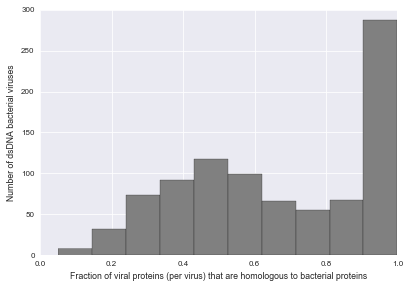

In [68]:
a=toph.groupby(['virusInfo'])['fractionOfHomologousProteins'].mean()
#In the above line, mean doesn't really do anything beacuse the fraction of homologous proteins is the same for each 
#virus.
plt.hist(a, color='gray')


plt.xlabel('Fraction of viral proteins (per virus) that are homologous to bacterial proteins')
plt.ylabel('Number of dsDNA bacterial viruses')
#plt.savefig('blast-fracHomoHist.pdf')
a.describe()


count    725.000000
mean       0.598649
std        0.248075
min        0.050000
25%        0.397059
50%        0.556962
75%        0.814229
max        1.000000
Name: fractionOfHomologousProteins, dtype: float64

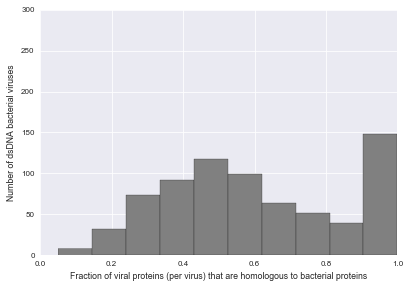

In [69]:
aa=tophProFil.groupby(['virusInfo'])['fractionOfHomologousProteins'].mean()

plt.hist(aa, color='gray')
plt.ylim(0,300)
plt.xlabel('Fraction of viral proteins (per virus) that are homologous to bacterial proteins')
plt.ylabel('Number of dsDNA bacterial viruses')
#plt.savefig('blast-fracHomoHist-woProphages.pdf')
aa.describe()

###Shedding some light on viral "hypothetical proteins" by identifying those that have homology to a bacterial protein

In [70]:
#First let's figure out how many phage proteins are unannotated (or specifically annotated as "hypothetical protein")
protL=[]
for virus in lengthData:
    if virus['englishLineage'][-1] in toph['virusInfo'].unique():
        protL.append(len([x for x in virus['proteinNames'] if re.search('hypothetical protein', x, re.IGNORECASE)]))
numHypoPhageProts=sum(protL)

print('The number of phage proteins that are annotated as hypothetical protein is: ',numHypoPhageProts)



The number of phage proteins that are annotated as hypothetical protein is:  51417


In [71]:
#creating a dataframe of viral hypothetical proteins that have bacterial homologs
hypoDf = toph[toph['queryDesc'].str.contains('hypothetical protein', case=False)]
print('Number of hypothetical viral proteins with homology to bacterial proteins: ', hypoDf.shape[0])

#A dataframe containing hypothetical viral proteins whose bacterial homolog is characterized
#we are throwing away proteins whose function is not known in the bacterial setting, by using keywords:
#uncharacterized, putatitve, and probable
charHypo = toph[(toph['queryDesc'].str.contains('hypothetical protein', case=False))
                       & (toph['hitProtDesc'].str.contains('hypothetical protein', case=False)==False)]
                          
#Number of hypothetical viral proteins whose bacterial homolog is characterized
print('Number of hypothetical viral proteins whose bacterial homolog is characterized: ',
      charHypo.shape[0])
#The number above divided by the total number of viral proteins in this analysis
print('Fraction of viral proteins with bacterial homologs that could be identified only'+
      ' through their bacterial homolog description, :', np.round(charHypo.shape[0]/totProtNum, 2))

#Saving the results to a text file.
#charHypo.to_csv('hypoPhageProtCharacterized-v2.txt', header=True, index=False, sep='\t')



Number of hypothetical viral proteins with homology to bacterial proteins:  21021
Number of hypothetical viral proteins whose bacterial homolog is characterized:  3727
Fraction of viral proteins with bacterial homologs that could be identified only through their bacterial homolog description, : 0.04


###Using the viral protein annotations to putatively characterize bacterial hypothetical proteins

In [72]:
#getting viral proteins that are annotated, and the bacterial proteins that are hypothetical
charBact = toph[(toph['queryDesc'].str.contains('hypothetical protein', case=False)==False)
                       & (toph['hitProtDesc'].str.contains('hypothetical protein', case=False)==False)]
print('Number of bacterial hypothetical proteins that are putatively annotated based on ' +
      'their viral homolog annotation :', charBact.shape[0])
#if you want to save the output, uncomment the following line
#charBact.to_csv('hypoBactProtCharacterized.txt', header=True, index=False, sep='\t')


Number of bacterial hypothetical proteins that are putatively annotated based on their viral homolog annotation : 16374


###Exploring the taxonomic diversity of bacterial homologs to viral proteins

In [73]:
#there are some entries where the taxonomic information for the organism where the BLAST hit is found could not be 
#provided. To carry out the following analysis we need that information and so those entries (corresponding to entire
#rows have been omitted) (i.e. tophFil represents a filtered toph dataframe). 
tophFil=toph[toph['phylum'].isnull()==False]
tophFil=tophFil[tophFil['class'].isnull()==False]
tophFil=tophFil[tophFil['order'].isnull()==False]
tophFil=tophFil[tophFil['family'].isnull()==False]
tophFil=tophFil[tophFil['genus'].isnull()==False]
tophFil=tophFil[tophFil['species'].isnull()==False]

#Also need to replace Enterobacterales with Enterobacteriales in the order column because it is a misspelling
tophFil['order']=tophFil['order'].str.replace('Enterobacterales', 'Enterobacteriales')

#these are viral proteins whose top homolog comes from a bacterium from a different phylum than the viral host
notPhy=tophFil[tophFil.apply(lambda tophFil: tophFil['phylum'] not in tophFil['hostInfo'], axis=1)]
print('number of hit proteins from organisms that are not even in the same phylum as the virus host: ', notPhy.shape[0])

#these are viral proteins whose top homolog comes from a bacterium from the same phylum as the viral host
phy=tophFil[tophFil.apply(lambda tophFil: tophFil['phylum'] in tophFil['hostInfo'], axis=1)]
print('number of hit proteins from organisms that are in the same phylum as the virus host: ', phy.shape[0])

#these are viral proteins whose top homolog comes from a bacterium from the same class as the viral host
cla= tophFil[tophFil.apply(lambda tophFil: tophFil['class'] in tophFil['hostInfo'], axis=1)]
print('number of hit proteins from organisms that are in the same class as the virus host: ', cla.shape[0])

#these are viral proteins whose top homolog comes from a bacterium from the same order as the viral host
order = tophFil[tophFil.apply(lambda tophFil: tophFil['order'] in tophFil['hostInfo'], axis=1)]
#getting rid of some instances of misannotated taxonomy. Specifically, the proper "class" isn't there eventhough
#the two entries share the same order. Similar checks have been done at different taxonomic levels, and only those
#with misannotations have been included here. 
order = order[order.apply(lambda order: order['class'] not in order['hostInfo'] , axis=1)==False]
print('number of hit proteins from organisms that are in the same order as the virus host: ', order.shape[0])

#these are viral proteins whose top homolog comes from a bacterium from the same family as the viral host
fam = tophFil[tophFil.apply(lambda tophFil: tophFil['family'] in tophFil['hostInfo'], axis=1)]
#getting rid of some instances of misannotated taxonomy
fam = fam[fam.apply(lambda fam: fam['order'] not in fam['hostInfo'] , axis=1)==False]
fam = fam[fam.apply(lambda fam: fam['class'] not in fam['hostInfo'] , axis=1)==False]
print('number of hit proteins from organisms that are in the same family as the virus host: ', fam.shape[0])

#these are viral proteins whose top homolog comes from a bacterium from the same genus as the viral host
gen = tophFil[tophFil.apply(lambda tophFil: tophFil['genus'] in tophFil['hostInfo'], axis=1)]
#getting rid of some instances of misannotated taxonomy
gen = gen[gen.apply(lambda gen: gen['family'] not in gen['hostInfo'] , axis=1)==False]
gen = gen[gen.apply(lambda gen: gen['order'] not in gen['hostInfo'] , axis=1)==False]
gen = gen[gen.apply(lambda gen: gen['class'] not in gen['hostInfo'] , axis=1)==False]
print('number of hit proteins from organisms that are in the same genus as the virus host: ', gen.shape[0])

#these are viral proteins whose top homolog comes from a bacterium from the same species as the viral host
spe = tophFil[tophFil.apply(lambda tophFil: tophFil['species'] in tophFil['hostInfo'], axis=1)]
#getting rid of some instances of misannotated taxonomy
spe = spe[spe.apply(lambda spe: spe['genus'] not in spe['hostInfo'] , axis=1) == False]
spe = spe[spe.apply(lambda spe: spe['family'] not in spe['hostInfo'] , axis=1)== False]
spe = spe[spe.apply(lambda spe: spe['class'] not in spe['hostInfo'] , axis=1)== False]
print('number of hit proteins from organisms that are in the same species as the virus host: ', spe.shape[0])


number of hit proteins from organisms that are not even in the same phylum as the virus host:  6626
number of hit proteins from organisms that are in the same phylum as the virus host:  34597
number of hit proteins from organisms that are in the same class as the virus host:  31112
number of hit proteins from organisms that are in the same order as the virus host:  27651
number of hit proteins from organisms that are in the same family as the virus host:  24855
number of hit proteins from organisms that are in the same genus as the virus host:  20198
number of hit proteins from organisms that are in the same species as the virus host:  11405


###How far (taxonomically) are the virus hosts from the organisms that harbor the closest homolog?

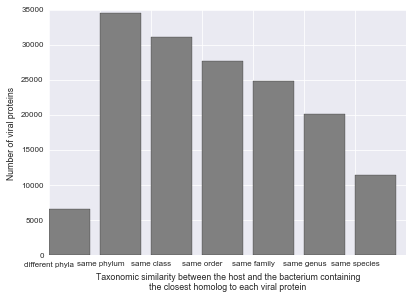

In [74]:
#Plotting the information from the last block of code
cats=('different phyla','same phylum', 'same class', 'same order', 'same family', 'same genus', 'same species')
y=[notPhy.shape[0],phy.shape[0],cla.shape[0],order.shape[0],fam.shape[0],gen.shape[0],spe.shape[0]]
yPos = np.arange(len(cats))

plt.bar(yPos, y,color='gray')
plt.xticks(yPos, cats)
plt.ylabel('Number of viral proteins')
plt.xlabel('Taxonomic similarity between the host and the bacterium containing' + 
           '\nthe closest homolog to each viral protein')
#plt.savefig('blastTaxonomy.pdf')


###A different representation of the figure above

(-1, 1)

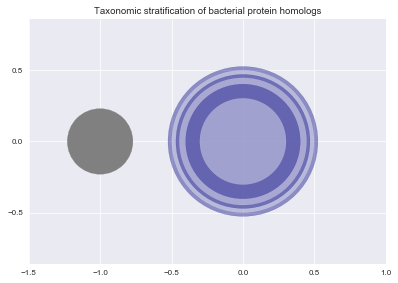

In [75]:
#going to show the above bar chart in a different format. Here the inscribed circles represent phylum, class...species
#bars. the outside cirlce represents the number of homologous proteins that come from a bacterial host from a different 
#phylum than the host phylum. The area of the circle represents the size of each group of homologous proteins. 
areas=[phy.shape[0],cla.shape[0],order.shape[0],fam.shape[0],gen.shape[0],spe.shape[0], notPhy.shape[0]]
r = [np.sqrt(area / (4*np.pi))/100 for area in areas]

z=.4
c='teal'
#homologs from a bacterium in the same phylum as the host
circle1 =plt.Circle((0, 0), r[0], color='navy', alpha=z) 
#homologs from a bacterium in the same class as the host
circle2 =plt.Circle((0, 0), r[1], color='white', alpha=z) 
#homologs from a bacterium in the same order as the host
circle3 =plt.Circle((0, 0), r[2], color='navy', alpha=z)
#homologs from a bacterium in the same family as the host
circle4 =plt.Circle((0, 0), r[3], color='white', alpha=z)
#homologs from a bacterium in the same genus as the host
circle5 =plt.Circle((0, 0), r[4], color='navy', alpha=z)
#homologs from a bacterium in the same species as the host                    
circle6 =plt.Circle((0, 0), r[5], color='white', alpha=z)
#homologs from a bacterium that is NOT from the same phylum as the host                    
circle7 =plt.Circle((-1, 0), r[6],color='gray', alpha=1)

fig, ax = plt.subplots() 
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.add_artist(circle5)
ax.add_artist(circle6)
ax.add_artist(circle7)
ax.axis('equal')

plt.title('Taxonomic stratification of bacterial protein homologs')
plt.xlim(-1.5,1)
plt.ylim(-1,1)
#plt.savefig('inscibedCircles.pdf')


###Creating bit score distributions (same species vs. same phylum)
Comparing homologs based on the quality of their match (i.e bit score) 



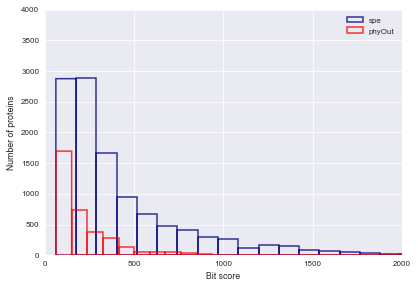

In [76]:
#to get at homologs that come from the same genus as the host, we need to exclude homologs that come from the same 
#species. The same idea for other layers in the inscribed circles diagram from above. 
genOut=gen[gen.isin(spe)==False].dropna()
phyOut=phy[phy.isin(cla)==False].dropna()
z=.8
x=1.5
y=50
plt.hist(spe['bitscore'],bins=y, alpha=z, label='spe', fill= False, edgecolor='navy', linewidth=x)
plt.hist(phyOut['bitscore'],bins=y,  alpha=z, label='phyOut', fill=False, edgecolor='red', linewidth=x)

plt.legend(loc='upper right')

plt.xlim(0,2000)
plt.ylim(0,4000)

plt.xlabel('Bit score')
plt.ylabel('Number of proteins')
#plt.savefig('speVsphyOut.pdf')


###Creating bit score distributions (same species vs. same genus)

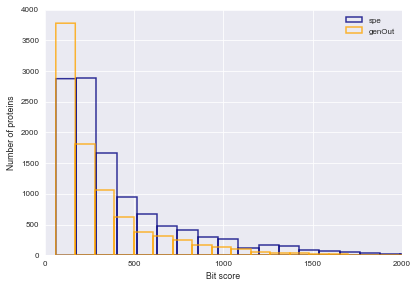

In [77]:
z=.8
x=1.5
y=50
plt.hist(spe['bitscore'],bins=y, alpha=z, label='spe', fill= False, edgecolor='navy', linewidth=x)
plt.hist(genOut['bitscore'],bins=y, alpha=z, label='genOut', fill=False, edgecolor='orange', linewidth=x)

plt.legend(loc='upper right')

plt.xlim(0,2000)
plt.ylim(0,4000)
plt.xlabel('Bit score')
plt.ylabel('Number of proteins')
#plt.savefig('speVsgenOut.pdf')


###Statistical significance testing
Using Mann Whitney U test (to avoid the assumption of a normal distribution) to check for a significant difference between the distributions shown above.


In [79]:
print('median bit score for same species group :', spe['bitscore'].median())
print('median bit score for same genus only group :', genOut['bitscore'].median())
print('median bit score for same phylum only group :', phyOut['bitscore'].median())
#one-sided MWU test
print(scipy.stats.mannwhitneyu(genOut['bitscore'], spe['bitscore'], use_continuity=True, alternative='less'))
print(scipy.stats.mannwhitneyu(phyOut['bitscore'], spe['bitscore'], use_continuity=True, alternative='less'))


median bit score for same species group : 285.0
median bit score for same genus only group : 201.0
median bit score for same phylum only group : 156.0
MannwhitneyuResult(statistic=37391160.5, pvalue=9.0858939246248494e-212)
MannwhitneyuResult(statistic=11135992.0, pvalue=0.0)


###Exploring the homologs coming from bacteria of different phyla than the host

hostPhylum              phylum             
Actinobacteria          Aquificae                 1
                        Bacteroidetes             7
                        Chlorobi                  1
                        Deinococcus-Thermus       1
                        Elusimicrobia             1
                        Firmicutes              100
                        Nitrospirae               4
                        Proteobacteria          261
                        Spirochaetes              3
Bacteroidetes/Chlorobi  Actinobacteria            7
                        Balneolaeota              3
                        Deferribacteres           1
                        Deinococcus-Thermus       2
                        Firmicutes              125
                        Fusobacteria              2
                        Proteobacteria           93
                        Spirochaetes              2
Cyanobacteria           Acidobacteria             4
                    

/Users/Gita/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


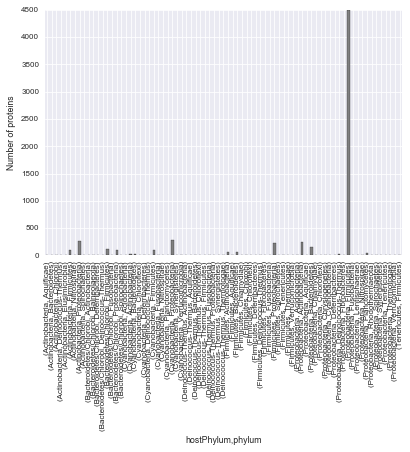

In [51]:
#notPhy corresponds to the gray circle (the ones where the homolog is coming from a bacterium from a different phylum
#than the host phylum)
notPhy['hostPhylum']= notPhy['condensedHostInfo'].apply(lambda row: row.split(' ')[0])
notPhy.groupby(['hostPhylum','phylum'])['qgi'].count().plot(kind='bar', color='gray')
plt.ylabel('Number of proteins')
plt.savefig('hostPhylaVsHomologPhyla.pdf')
print(notPhy.groupby(['hostPhylum','phylum'])['qgi'].count())


###Distribution of host phyla 

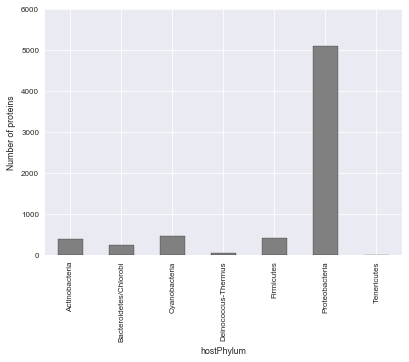

In [649]:
#these are the host phyla from the notPhy group
notPhy.groupby('hostPhylum')['qgi'].count().plot(kind='bar', color='gray')
plt.ylabel('Number of proteins')
plt.savefig('blast-hostPhylaBarChart.pdf')


###Distribution of phyla that contain the homologous proteins 

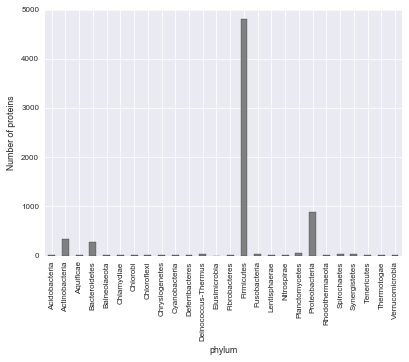

In [297]:
#these are the phyla where the homologs come from
notPhy.groupby('phylum')['qgi'].count().plot(kind='bar', color='gray')
plt.ylabel('Number of proteins')
#plt.savefig('blast-homologPhylaBarChart.pdf)
            

##Let's move on to quantifying the sequence similarity between bacteriophage structural proteins within/across different host groups

###Writing a text file containing terminase sequences (large subunit) from different dsDNA bacteriophages

In [187]:
filename = 'largeTerminaseSeqs.txt'
fo = open(filename, 'w')
termLfolder=[]
count=0

#Getting the names of viruses that are dsDNA bacteriophages
folderL= [v['folder'] for v in lengthData if 'Bacteria' in v['hostEnglishLineage'] and 
          'dsDNA viruses, no RNA stage' in v['englishLineage']]

#Getting the amino acid sequences for terminases (large subunit)
for folder in os.listdir('all_faa'):
    if folder in folderL:
        for file in os.listdir(os.path.join('all_faa', folder)):  
            with open(os.path.join('all_faa', folder, file)) as faa_file:
                prots=SeqIO.parse(faa_file, 'fasta')
                for prot in prots:
                    #searching for the term terminase large subunit in the protein description
                    if re.search('terminase large subunit', prot.description, re.IGNORECASE):
                        count=count+1
                        termLfolder.append([folder, prot.description.split(' ')[0]])
                        #writing the resulting sequences to a file
                        fo.write('>'+prot.description +'\n' + str(prot.seq)+'\n')
fo.close()
print('number of terminase large subunit sequences: ', count)


number of terminase large subunit sequences:  320


###Visualizing the result of the multiple alignment of terminase large subunit sequences

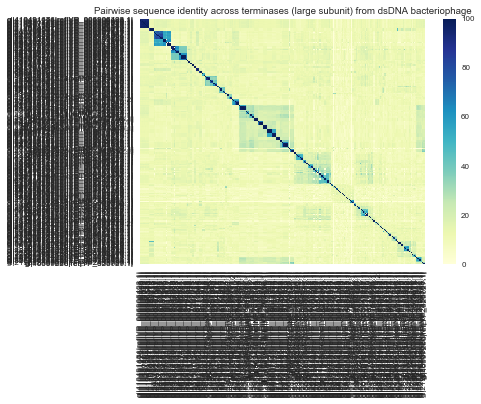

In [277]:
#the pairwise sequence comparison (percent similarity matrix) is uploaded here for visualization
matL=pd.read_csv('terminaseLmatrix.txt', sep='\t', index_col=0)
matL=matL.fillna(0)
ax = sns.heatmap(matL, cmap="YlGnBu")
plt.title('Pairwise sequence identity across terminases (large subunit) from dsDNA bacteriophage')
plt.savefig('matrixLargeTerminase.pdf')



###Plotting host color labels for the above heatmap

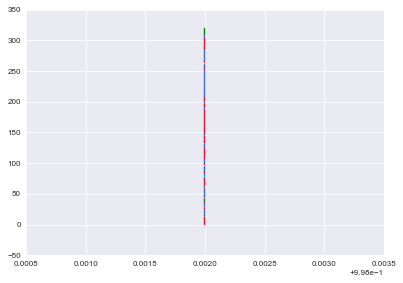

In [282]:
#Getting a list of terminase seq records (i.e. gi number)
matLcol=matL.columns.tolist()
termLfolderSorted=[]
for col in matLcol:
    for index, vec in enumerate(termLfolder):
        if termLfolder[index][1]== col:
            termLfolderSorted.append(termLfolder[index])
                        

#Getting the host phylum for each terminase sequences
hostList=[]
hostPhylaList=[]
for vec in termLfolderSorted:
    for virus in lengthData: 
        if vec[0] == virus['folder']:
            #getting the entire host lineage
            hostList.append(virus['hostEnglishLineage'])
            #getting the host phylum
            hostPhylaList.append(virus['hostEnglishLineage'][3])

#print(hostList)
#Now let's create a color-coded label for the heatmap based on the host phylum of each terminase sequence
#c will hold a list of colors, corresponding to each host phylum. 
c=[]
for phylum in hostPhylaList:
    if phylum == 'Deinococcus-Thermus':
        c.append('yellow')
    if phylum == 'Actinobacteria':
        c.append('green')
    if phylum == 'Firmicutes':
        c.append('crimson')
    if phylum == 'Bacteroidetes/Chlorobi group':
        c.append('grey')
    if phylum == 'Cyanobacteria':
        c.append('cyan')
    elif phylum == 'Proteobacteria':
        c.append('royalblue')

#when plotting we need an x and a y position. The x can be 1, and the y needs to go from 0 to the length of the c list
x=[1]*len(c)
y=list(range(len(c)))

plt.scatter(x, y[::-1], color=c, s=1, marker ='s')
plt.savefig('phylumLabelsLargeTerminase.pdf')



###Writing a text file containing terminase sequences (small subunit) from different dsDNA bacteriophages

In [11]:
filename = 'smallTerminaseSeqs.txt'
fo = open(filename, 'w')
termSfolder=[]
count=0
#Getting the names of viruses that are dsDNA bacteriophages
folderS= [v['folder'] for v in lengthData if 'Bacteria' in v['hostEnglishLineage'] and 
          'dsDNA viruses, no RNA stage' in v['englishLineage']]

#Getting the amino acid sequences for terminases (large subunit)
for folder in os.listdir('all_faa'):
    if folder in folderS:
        for file in os.listdir(os.path.join('all_faa', folder)):  
            with open(os.path.join('all_faa', folder, file)) as faa_file:
                prots=SeqIO.parse(faa_file, 'fasta')
                for prot in prots:
                    #searching for the term terminase small subunit in the protein description
                    if re.search('terminase small subunit', prot.description, re.IGNORECASE):
                        count=count+1
                        termSfolder.append([folder, prot.description.split(' ')[0]])
                        #writing the sequences to a file
                        fo.write('>'+prot.description +'\n' + str(prot.seq)+'\n')
                        
fo.close()
print('number of terminase small subunit sequences: ', count)


number of terminase small subunit sequences:  191


###Visualizing the result of the multiple alignment of terminase small subunit sequences

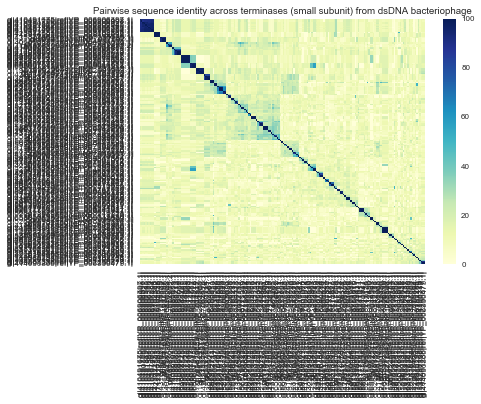

In [12]:
#the pairwise sequence comparison (percent similarity matrix) is uploaded here for visualization
matS=pd.read_csv('terminaseSmatrix.txt', sep='\t', index_col=0)
matS=matS.fillna(0)
ax = sns.heatmap(matS, cmap="YlGnBu")
plt.title('Pairwise sequence identity across terminases (small subunit) from dsDNA bacteriophage')
plt.savefig('matrixSmallTerminase.pdf')


###Plotting host color labels for the above heatmap

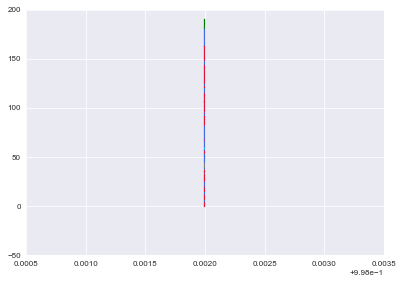

In [13]:
matScol=matS.columns.tolist()
termSfolderSorted=[]
for col in matScol:
    for index, vec in enumerate(termSfolder):
        if termSfolder[index][1]== col:
            termSfolderSorted.append(termSfolder[index])
                        
#Getting the host phylum for each terminase sequences
hostList=[]
hostPhylaList=[]
for vec in termSfolderSorted:
    for virus in lengthData: 
        if vec[0] == virus['folder']:
            hostList.append(virus['hostEnglishLineage'])
            hostPhylaList.append(virus['hostEnglishLineage'][3])

#print(hostList)
c=[]
for phylum in hostPhylaList:
    if phylum == 'Deinococcus-Thermus':
        c.append('yellow')
    if phylum == 'Actinobacteria':
        c.append('green')
    if phylum == 'Firmicutes':
        c.append('crimson')
    if phylum == 'Bacteroidetes/Chlorobi group':
        c.append('grey')
    if phylum == 'Cyanobacteria':
        c.append('cyan')
    elif phylum == 'Proteobacteria':
        c.append('royalblue')

#when plotting we need an x and a y position. The x can be 1, and the y needs to go from 0 to the length of the c list
x=[1]*len(c)
y=list(range(len(c)))

plt.scatter(x, y[::-1], color=c, s=1, marker ='s')
#This color label map is enlarged in illustrator and placed next to the heatmap
plt.savefig('phylumLabelsSmallTerminase.pdf')
